In [1]:
import pandas as pd
import numpy as np
import re
import os
import torch

from transformers import pipeline
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import AutoModelForSeq2SeqLM, pipeline

from tqdm.notebook import tqdm
tqdm.pandas()
import warnings
warnings.simplefilter("ignore")

## Load data

In [96]:
file_path = r"/home/voldemort/data_science/projects/basics/workshop/data/amazon_uk_shoes_products_dataset_2021_12.csv"

In [3]:
def get_gender(x):
    if "women" in x.lower():
        return "women"
    elif "men" in x.lower():
        return "men"
    elif "boy" in x.lower():
        return "boy"
    elif "girl" in x.lower():
        return "girl"
    else:
        return "unisex"

In [97]:
df = pd.read_csv(file_path)
df = df.loc[~df.review_text.isna()]
df = df.loc[df.review_rating<3].reset_index(drop=True)
#df = df[["product_name","review_text"]]
df["brand"] = df.product_name.apply(lambda x:x.split()[0])
df["gender"] = df.product_name.apply(get_gender)

## Language identification

In [5]:
# load a llm specialised for the language detection 

language_detection_llm_name = "papluca/xlm-roberta-base-language-detection"
lang_identifier_tokenizer = AutoTokenizer.from_pretrained(language_detection_llm_name)
lang_identifier_model = AutoModelForSequenceClassification.from_pretrained(language_detection_llm_name)

In [9]:
language_dict = {
    "ar": "arabic","bg": "bulgarian","de": "german","el": "greek","en": "english","es": "spanish","fr": "french",
    "hi": "hindi","it": "italian","ja": "japanese","nl": "dutch","pl": "polish","pt": "portuguese","ru": "russian",
    "sw": "swahili","th": "thai","tr": "turkish","ur": "urdu","vi": "vietnamese","zh": "chinese"
}

def identify_language(text):

    inputs = lang_identifier_tokenizer(text, padding=True, truncation=True, return_tensors="pt")

    with torch.no_grad():
        logits = lang_identifier_model(**inputs).logits
    
    preds = torch.softmax(logits, dim=-1)
    id2lang = lang_identifier_model.config.id2label
    vals, idxs = torch.max(preds, dim=1)
    return {id2lang[k.item()]: v.item() for k, v in zip(idxs, vals)}

In [10]:
df["language"] = df.review_text.progress_apply(identify_language)

  0%|          | 0/1043 [00:00<?, ?it/s]

In [25]:
df["language"] = df["language"].apply(lambda x : list(x.keys())[0])

In [30]:
df["language_name"] = df.language.apply(lambda x:language_dict.get(x))

In [31]:
df["language_name"].value_counts()

language_name
english       703
german        123
spanish       123
italian        54
french         31
japanese        4
turkish         2
portuguese      2
russian         1
Name: count, dtype: int64

## Language Translation

In [15]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-de")

model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-de")

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/768k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/797k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/298M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [18]:
def translate(text, target_language):
    inputs = tokenizer.encode(text, return_tensors="pt")
    outputs = model.generate(inputs, num_beams=4, max_length=256, early_stopping=True)
    translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return translated_text

In [33]:
checkpoint = "facebook/nllb-200-distilled-600M"
model_nllb = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
tokenizer_nllb = AutoTokenizer.from_pretrained(checkpoint)

In [69]:
def get_translated_text(text,source_lang,target_lang="en_Latn"):

    source_lang += "_Latn"
    if source_lang != target_lang:
        translator = pipeline("translation", model=model_nllb, tokenizer=tokenizer_nllb,src_lang=source_lang,tgt_lang=target_lang, max_length = 512,
                          device = "cuda"
                          )
        output = translator(text)
        translated_text = output[0]["translation_text"]
        return translated_text  
    else:
        return text

In [70]:
df["reviews_processed"] = df.progress_apply(lambda x:get_translated_text(x.review_text,source_lang=x.language),axis=1)

  0%|          | 0/1043 [00:00<?, ?it/s]

Your input_length: 742 is bigger than 0.9 * max_length: 512. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


In [71]:
df.head()

,product_name,review_text,brand,gender,language,language_name,reviews_processed
0,Klasified Women's Transparent Clear Sneaker Sh...,"The shoes are very cute, but after the 2nd day...",Klasified,women,en,english,"The shoes are very cute, but after the 2nd day..."
1,"GUESS Women's Bradly Gymnastics Shoe, White, 7 UK",Sono solita comprare scarpe Guess e non ho mai...,GUESS,women,it,italian,"Guess i never had any problems with the size, ..."
2,"adidas Women's Retrorun Shoes Running, Core Bl...",This is the second pair I bought. Loved the fi...,adidas,women,en,english,This is the second pair I bought. Loved the fi...
3,"adidas Women's Retrorun Shoes Running, Core Bl...",I would NOT recommend these for running. They ...,adidas,women,en,english,I would NOT recommend these for running. They ...
4,"Aravon Women's Betty-AR Oxfords, Stone, 5.5 UK",These shoes are cute online but in person...no...,Aravon,women,en,english,These shoes are cute online but in person...no...


In [72]:
df.to_csv("/home/voldemort/data_science/projects/basics/workshop/data/amz_uk_shoes_processed_stage_2.csv")

## Question Answering

In [73]:
qa_chatbot = pipeline("question-answering",model="distilbert-base-cased-distilled-squad",device=0)

In [74]:
def get_root_cause(brand,gender,review_text):
    try:
        res = qa_chatbot(
            question=f"What is the issue with {brand} {gender}'s foot wear here?",
            context=review_text
            )
        
        return res.get("answer","unknown")
    except Exception as e:
        print(brand,gender,review_text)
        return "unknown"

In [76]:
df["root_cause"] = df.progress_apply(lambda x:get_root_cause(x.brand,x.gender,x.reviews_processed),axis=1)

  0%|          | 0/1043 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Dockers women 
ACE men 
FILA unisex 


In [77]:
df.to_csv("/home/voldemort/data_science/projects/basics/workshop/data/amz_uk_shoes_processed.csv")

## Word cloud

In [78]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

In [79]:
stopwords = set(STOPWORDS)

In [81]:
df["description"] = df["root_cause"].apply(lambda x:x.replace("shoe","").lower())

In [82]:
comment_words = ''

for val in df.description:
     
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "

In [83]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

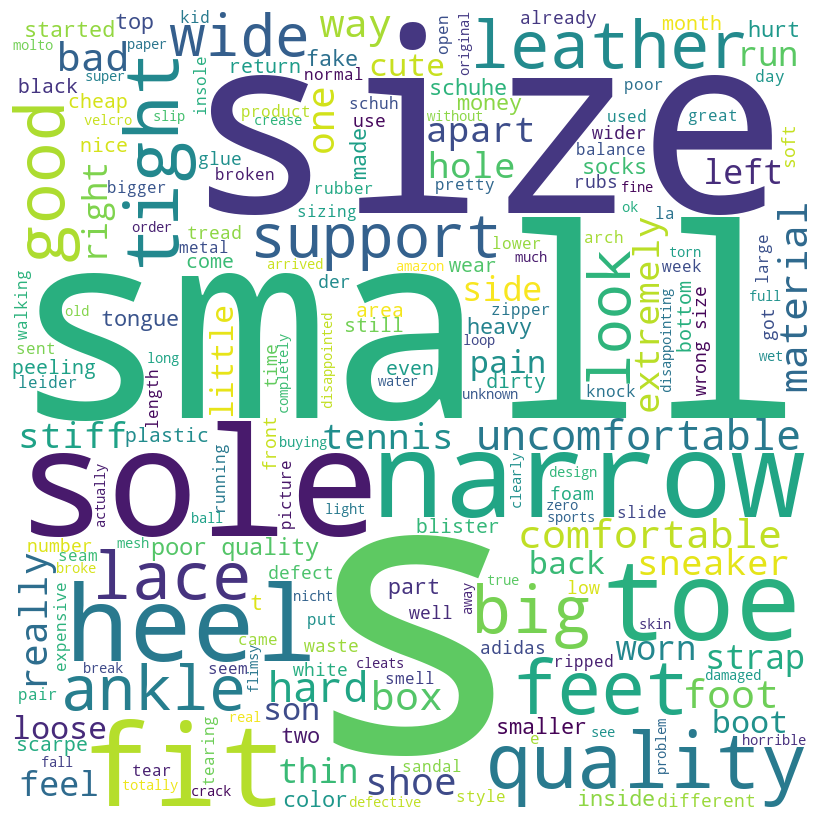

In [92]:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)